In [130]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import time
import math
import scipy.io
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
import datetime

In [131]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [132]:
NX, NY, ghostp = 50, 50, 5
xmin = 0.00
xmax = 1.0

ymin = 0.00
ymax = 1.00

x, y = np.ones(NX + 2 * ghostp, dtype=np.float64), np.ones(NY + 2 * ghostp, dtype=np.float64)
dx = (xmax - xmin) / NX
dy = (ymax - ymin) / NY

for i in range(NX + 2 * ghostp):
    x[i] = xmin + (i - ghostp + 1 - 0.5) * dx

for j in range(NY + 2 * ghostp):
    y[j] = ymin + (j - ghostp + 1 - 0.5) * dy

XF, YF = np.meshgrid(x, y)
xf = x[5:55]
yf = y[5:55]

X, Y = np.meshgrid(xf, yf)
X_t = X.flatten()
Y_t = Y.flatten()

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_14812\2713045675.py:37: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(_d, con_lv, origin='lower', cmap='rainbow', aspect='auto');


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_14812\2713045675.py:42: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(_u, con_lv, origin='lower', cmap='rainbow', aspect='auto');
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_14812\2713045675.py:48: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(_v, con_lv, origin='lower', cmap='rainbow', aspect='auto');
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_14812\2713045675.py:53: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(_p, con_lv, origin='lower', cmap='rainbow', aspect='auto');


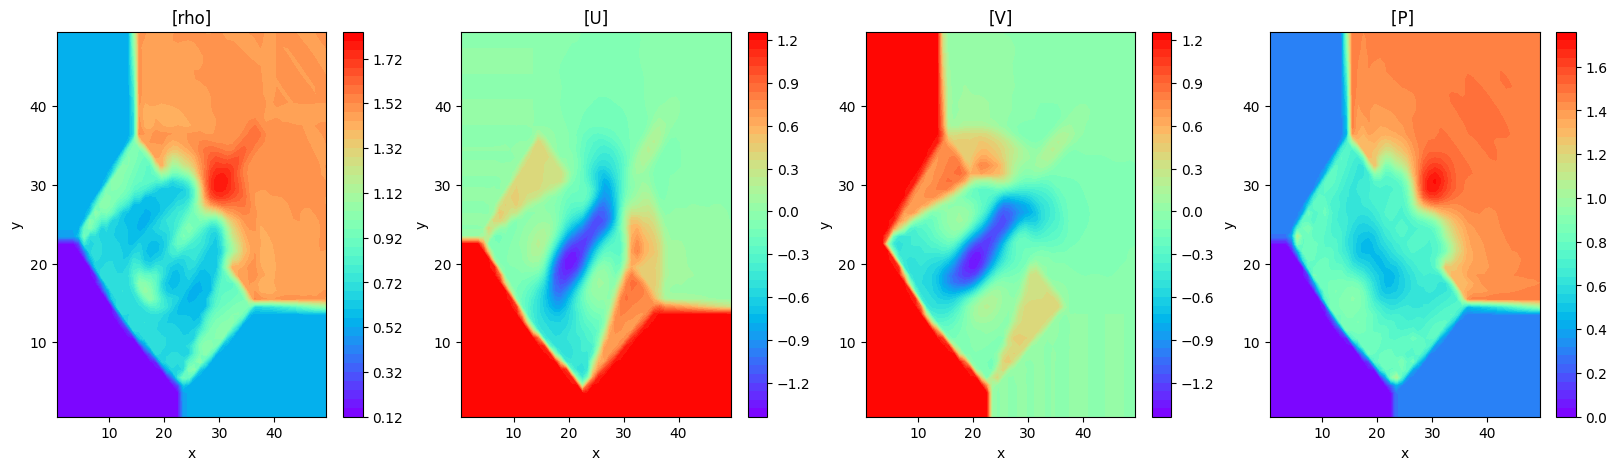

In [133]:
sim_d = np.loadtxt('data_rho.csv', delimiter=',')
sim_u = np.loadtxt('data_u.csv', delimiter=',')
sim_v = np.loadtxt('data_v.csv', delimiter=',')
sim_p = np.loadtxt('data_p.csv', delimiter=',')
res_d = np.loadtxt('475 res_r.csv', delimiter=',')
res_u = np.loadtxt('475 res_u.csv', delimiter=',')
res_v = np.loadtxt('475 res_v.csv', delimiter=',')
res_p = np.loadtxt('475 res_p.csv', delimiter=',')
#print(sim_d.shape)
sim_d = sim_d[6:56, 6:56]
sim_u = sim_u[6:56, 6:56]
sim_v = sim_v[6:56, 6:56]
sim_p = sim_p[6:56, 6:56]
sim_d_F = sim_d.reshape(-1)
sim_u_F = sim_u.reshape(-1)
sim_v_F = sim_v.reshape(-1)
sim_p_F = sim_p.reshape(-1)
#print(sim_d)
residual = np.zeros((res_d.shape[0] - 1, res_d.shape[1] - 1 ,4), dtype=np.float64)
residual[:, :, 0] = res_d[1:, 1:]
residual[:, :, 1] = res_u[1:, 1:]
residual[:, :, 2] = res_v[1:, 1:]
residual[:, :, 3] = res_p[1:, 1:]
# spatial-temporal domain
#T = 1.0   #2


# computational boundary

# visualize simulation data
fig = plt.figure(figsize=(20, 5))
con_lv = 50
# u
ax1 = fig.add_subplot(1,4,1)

_d = sim_d
plt.contourf(_d, con_lv, origin='lower', cmap='rainbow', aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[rho]');

ax1 = fig.add_subplot(1,4,2)
_u = sim_u
plt.contourf(_u, con_lv, origin='lower', cmap='rainbow', aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[U]');

# v
ax1 = fig.add_subplot(1,4,3)
_v = sim_v
plt.contourf(_v, con_lv, origin='lower', cmap='rainbow', aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[V]' );
# p
ax1 = fig.add_subplot(1,4,4)
_p = sim_p
plt.contourf(_p, con_lv, origin='lower', cmap='rainbow', aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[P] ');

In [134]:
# dx & dy
n = 50
X_f_test = np.hstack((XF.flatten()[:,None], YF.flatten()[:,None]))
# training sample (x * y) -> (u, v, p)
X_u_test = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
lb = X_u_test[0]
ub = X_u_test[-1]
BN = False
u = np.hstack((sim_d_F.flatten('F')[:,None] , sim_u_F.flatten('F')[:,None] , sim_v_F.flatten('F')[:,None] , sim_p_F.flatten('F')[:,None] ))

print (X_u_test.shape, u.shape)

(2500, 2) (2500, 4)


In [ ]:
bc=np.random.randint(2500, size=(1000))
X_u_train , u_train = X_u_test[bc], u[bc]
X_f_train = X_f_test

print ('# BC sample = %d' %len(u_train))

# view
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,2,1); _sc = 1.
plt.scatter(X_u_train[:, 0], X_u_train[:, 1], c=np.ones(u_train[:, 1].shape), marker='H', s=1, alpha=.85, cmap='rainbow'); plt.title('u-vel');
ax1 = fig.add_subplot(1,2,2); _sc = .5
plt.scatter(X_u_train[:, 0], X_u_train[:, 1], c=np.ones(u_train[:, 2].shape), marker='H', s=1, alpha=.85, cmap='rainbow'); plt.title('v-vel');

In [147]:
class PINN(tf.Module): 
    def __init__(self, layers, residual, lb, ub, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        self.layers = layers
        self.residual = residual

        # for i in range(len(layers)-1):
            
        #     input_dim = layers[i]
        #     output_dim = layers[i+1]
            
        #     #Xavier standard deviation 
        #     std_dv = np.sqrt((2.0/(input_dim + output_dim)))

        #     #weights = normal distribution * Xavier standard deviation + 0
        #     w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
        #     w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

        #     b = tf.Variable(tf.cast(tf.ones([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
        #     self.W.append(w)
        #     self.W.append(b)
            
        #     self.parameters +=  input_dim * output_dim + output_dim
            
        lr = 0.001
        self.optimizer = self.opt_alg(lr, "Adam")

        self.dnn = self.dnn_init(layers)
        self.params = self.dnn.trainable_variables

        self.lb = lb
        self.ub = ub
        self.BN = False
        self.data_type  = tf.float64
        self.ep_log = []
        self.loss_log = []

    
    def opt_alg(self, lr, opt):
        if   opt == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = False)
        elif opt == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False)
        elif opt == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        elif opt == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        elif opt == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        else:
            raise Exception(">>>>> Exception: optimizer not specified correctly")

        return optimizer
    
    
    
    def dnn_init(self, layers):
        # network configuration (N: Rm -> Rn (Rm -> Rl -> ... -> Rl -> Rn))
        network = tf.keras.Sequential()
        network.add(tf.keras.layers.InputLayer(layers[0]))
        network.add(tf.keras.layers.Lambda(lambda x: 2. * (x - lb) / (ub - lb) - 1.))

        if BN == True:   # False by default
            for l in range(1, len(layers) - 1):
                network.add(tf.keras.layers.Dense(layers[l], activation = "tanh", use_bias = False,
                                                  kernel_initializer = "glorot_normal", bias_initializer = "zeros",
                                                  kernel_regularizer = None, bias_regularizer = None,
                                                  activity_regularizer = None, kernel_constraint = None, bias_constraint = None))
                network.add(tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001,
                                                               center = True, scale = True,
                                                               beta_initializer = "zeros", gamma_initializer = "ones",
                                                               moving_mean_initializer = "zeros",
                                                               moving_variance_initializer = "ones",
                                                               beta_regularizer = None, gamma_regularizer = None,
                                                               beta_constraint  = None, gamma_constraint  = None))

        else:   # False by default
            for l in range(1, len(layers) - 1):
                network.add(tf.keras.layers.Dense(layers[l], activation = "tanh", use_bias = True,
                                                  kernel_initializer = "glorot_normal", bias_initializer = "zeros",
                                                  kernel_regularizer = None, bias_regularizer = None,
                                                  activity_regularizer = None, kernel_constraint = None, bias_constraint = None))
        network.add(tf.keras.layers.Dense(layers[-1]))
        return network
    
    def evaluate(self,x):
        
        a = self.dnn(x)
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(self.layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(self.layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 
    

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
        # print("STARTEDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD")
        # U = tf.Variable(self.residual, dtype = 'float64', trainable = True)
        U = self.evaluate(x_to_train_f)
        U = tf.reshape(U, [60, 60, 4])
        residual = self.residual
        CFL, gamma = 0.19, 1.4
        NX, NY, ghostp, n_eqn = 50, 50, 5, 4
        x, y = x_to_train_f[:, 0], x_to_train_f[:, 1]
        test_case = 1
        time = 0.8
        def boundaryconditions(U, x, y, time, gamma, NX, NY, ghostp, test_case):

            if test_case == 1:
                # Set left and right boundary conditions.
                for i in range(1, ghostp + 1):
                    for j in range(ghostp, NY + ghostp):
                        U = tf.tensor_scatter_nd_update(U, [[- i + ghostp, j, 0], [- i + ghostp, j, 1], [- i + ghostp, j, 2], [- i + ghostp, j, 3], \
                                                    [NX + ghostp + i - 1, j, 0], [NX + ghostp + i - 1, j, 1], [NX + ghostp + i - 1, j, 2], [NX + ghostp + i - 1, j, 3]], \
                                                                [U[ghostp + i - 1, j, 0], U[ghostp + i - 1, j, 1], U[ghostp + i - 1, j, 2], U[ghostp + i - 1, j, 3], \
                                                                 U[NX - i + ghostp, j, 0], U[NX - i + ghostp, j, 1], U[NX - i + ghostp, j, 2], U[NX - i + ghostp, j, 3]])

                # Set top and bottom boundary condition
                for j in range(1, ghostp + 1):
                    for i in range(ghostp, NX + ghostp):
                        U = tf.tensor_scatter_nd_update(U, [[i, -j + ghostp, 0], [i, -j + ghostp, 1], [i, -j + ghostp, 2], [i, -j + ghostp, 3], \
                                                    [i, NY + ghostp + j - 1, 0],[i, NY + ghostp + j - 1, 1],[i, NY + ghostp + j - 1, 2],[i, NY + ghostp + j - 1, 3]], \
                                                                [U[i, ghostp + j - 1, 0],U[i, ghostp + j - 1, 1],U[i, ghostp + j - 1, 2], U[i, ghostp + j - 1, 3], \
                                                                U[i, NY - j + ghostp, 0],U[i, NY - j + ghostp, 1],U[i, NY - j + ghostp, 2],U[i, NY - j + ghostp, 3]])
            else:
                print("Oi, wrong")

            return U
        

        def minmod2(X, Y):
            return 0.5 * (math.copysign(1.0, X) + math.copysign(1.0, Y)) * min(abs(X), abs(Y))

        def GRAB(NS, un, priml, primr, mx, my, ghostp, n_eqn):
            v = np.ones((6, n_eqn), dtype=np.float64)
            charstencil = np.ones(5, dtype=np.float64)
            vd1 = np.ones((6, n_eqn), dtype=np.float64)
            char_ddx = np.ones(5, dtype=np.float64)
            lefteigen = np.ones((4,4), dtype=np.float64)
            righteigen = np.ones((4,4), dtype=np.float64)
            ul = np.ones(n_eqn, dtype=np.float64)
            ur = np.ones(n_eqn, dtype=np.float64)
            du_dx = np.ones((NS + 2*ghostp, n_eqn), dtype=np.float64)

            B2 = 4.0 / 3.0
            MP5 = 7.0
            EPSM = 1.0e-40
            alpha = 4.0
            gamma = 1.4

            lx = -my
            ly = mx

            for k in range(n_eqn):
                for i in range(ghostp - 1, ghostp + NS):
                    du_dx = tf.tensor_scatter_nd_update(du_dx, [[i,k]], \
                                    [(-(1.0/60.0)*un[i-3,k] + (3.0/20.0)*un[i-2,k]- (3.0/4.0)*un[i-1,k] +(3.0/4.0)*un[i+1,k]- (3.0/20.0)*un[i+2,k] + (1.0/60.0)*un[i+3,k])])
            for ix in range(ghostp - 1, NS + ghostp):
                sqrt_rho_L = math.sqrt(abs(un[ix, 0]))
                sqrt_rho_R = math.sqrt(abs(un[ix+1, 0]))

                rho = math.sqrt(abs((un[ix+1, 0] / un[ix, 0]) * un[ix, 0]))


                divisor = 1.0 / (sqrt_rho_R + sqrt_rho_L)

                p = ((un[ix, 3] * sqrt_rho_L) + (un[ix+1, 3] * sqrt_rho_R)) * divisor
                c = math.sqrt(abs(gamma * p / rho))

                righteigen = ([[1.0, 0.0, 1.0, 1.0],
                                    [-mx*c/rho, lx/rho, 0.0, mx*c/rho],
                                    [-my*c/rho, ly/rho, 0.0, my*c/rho],
                                    [c**2.0, 0.0, 0.0, c**2.0]])

                lefteigen = ([[0.0, -mx*rho*0.5/c, -my*rho*0.5/c, 0.5/c**2.0],
                                    [0.0, lx*rho, ly*rho, 0.0],
                                    [1.0, 0.0, 0.0, -1.0/c**2.0],
                                    [0.0, mx*rho*0.5/c, my*rho*0.5/c, 0.5/c**2.0]])


                for i in range(6):
                    for L in range(n_eqn):
                        v = tf.tensor_scatter_nd_update(v, [[i, L]], \
                                    [lefteigen[L][0]*un[i + ix -2,0] + lefteigen[L][1]*un[i+ix -2,1] + lefteigen[L][2]*un[i+ix -2,2] + lefteigen[L][3]*un[i+ix -2,3]])
                        vd1 = tf.tensor_scatter_nd_update(vd1, [[i, L]], \
                                    [lefteigen[L][0]*du_dx[i + ix -2,0] + lefteigen[L][1]*du_dx[i + ix -2,1] + \
                                         lefteigen[L][2]*du_dx[i + ix -2,2] + lefteigen[L][3]*du_dx[i + ix -2,3]])

                for i in range(n_eqn):
                    for L in range(5):
                        charstencil = tf.tensor_scatter_nd_update(charstencil, [[L]], \
                                    [v[L, i]])
                        char_ddx = tf.tensor_scatter_nd_update(char_ddx, [[L]], \
                                    [vd1[L, i]])

                    VOR = charstencil[2] + (1.0/2.0)*char_ddx[2] + \
                        ((-4.0+2.0)*0.25*(char_ddx[3]-char_ddx[1]) + \
                        (4.0*0.5)*(charstencil[1] - 2.0*charstencil[2] +charstencil[3]))/12.0

                    VMP = charstencil[2] + minmod2(charstencil[3] - charstencil[2], MP5 * (charstencil[2] - charstencil[1]))

                    if ((VOR - charstencil[2]) * (VOR - VMP) < EPSM):
                        ul = tf.tensor_scatter_nd_update(ul, [[i]], \
                                    [VOR])
                    else:
                        DJM1 = (charstencil[0] - 2.0 * charstencil[1] + charstencil[2])
                        DJ = (charstencil[1] - 2.0 * charstencil[2] + charstencil[3])
                        DJP1 = (charstencil[2] - 2.0 * charstencil[3] + charstencil[4])

                        DM4JPH = minmod2(DJ, DJP1)
                        DM4JMH = minmod2(DJ, DJM1)

                        VUL = charstencil[2] + MP5 * (charstencil[2] - charstencil[1])
                        VAV = 0.5 * (charstencil[2] + charstencil[3])
                        VMD = VAV - 0.5 * DM4JPH
                        VLC = charstencil[2] + 0.5 * (charstencil[2] - charstencil[1]) + B2 * DM4JMH

                        VMIN = max(min(charstencil[2], charstencil[3], VMD), min(charstencil[2], VUL, VLC))
                        VMAX = min(max(charstencil[2], charstencil[3], VMD), max(charstencil[2], VUL, VLC))

                        ul = tf.tensor_scatter_nd_update(ul, [[i]], \
                                    [VOR + minmod2(VMIN - VOR, VMAX - VOR)])

                    for L in range(5):
                        charstencil = tf.tensor_scatter_nd_update(charstencil, [[L]], \
                                    [v[L + 1, i]])
                        char_ddx = tf.tensor_scatter_nd_update(char_ddx, [[L]], \
                                    [vd1[L + 1, i]])

                    VOR = charstencil[2] - (1.0 / 2.0) * char_ddx[2] + \
                        ((-4.0 + 2.0) * 0.25 * (char_ddx[3] - char_ddx[1]) + \
                        (4.0 * 0.5) * (charstencil[1] - 2.0 * charstencil[2] + charstencil[3])) / 12.0

                    VMP = charstencil[2] + minmod2(charstencil[1] - charstencil[2], MP5 * (charstencil[2] - charstencil[3]))

                    if ((VOR - charstencil[2]) * (VOR - VMP) < EPSM):
                        ur = tf.tensor_scatter_nd_update(ur, [[i]], \
                                    [VOR])
                    else:
                        DJM1 =(charstencil[0] - 2.0 * charstencil[1] + charstencil[2])
                        DJ = (charstencil[1] - 2.0 * charstencil[2] + charstencil[3])
                        DJP1 =(charstencil[2] - 2.0 * charstencil[3] + charstencil[4])

                        DM4JPH = minmod2(DJ, DJP1)
                        DM4JMH = minmod2(DJ, DJM1)


                        VUL = charstencil[2] + MP5 * (charstencil[2] - charstencil[3])
                        VAV = 0.5 * (charstencil[2] + charstencil[1])
                        VMD = VAV - 0.5 * DM4JMH

                        VLC = charstencil[2] + 0.5 * (charstencil[2] - charstencil[3]) + B2 * DM4JPH

                        VMIN = max(min(charstencil[2], charstencil[1], VMD), min(charstencil[2], VUL, VLC))
                        VMAX = min(max(charstencil[2], charstencil[1], VMD), max(charstencil[2], VUL, VLC))

                        ur = tf.tensor_scatter_nd_update(ur, [[i]], \
                                    [VOR + minmod2(VMIN - VOR, VMAX - VOR)])


                for L in range(n_eqn):
                    primr = tf.tensor_scatter_nd_update(primr, [[ix, L]], \
                                    [righteigen[L][0]*ur[0] + righteigen[L][1]*ur[1] + \
                                    righteigen[L][2]*ur[2] + righteigen[L][3]*ur[3]])
                    priml = tf.tensor_scatter_nd_update(priml, [[ix, L]], \
                                    [righteigen[L][0]*ul[0] + righteigen[L][1]*ul[1] + \
                                    righteigen[L][2]*ul[2] + righteigen[L][3]*ul[3]])
                    
                if ( primr[ix,0] < 0): primr = tf.tensor_scatter_nd_update(primr, [[ix, 0]], [un[ix + 1, 0]])
                if ( primr[ix,3] < 0): primr = tf.tensor_scatter_nd_update(primr, [[ix, 3]], [un[ix + 1, 3]])
                if ( priml[ix,0] < 0): priml = tf.tensor_scatter_nd_update(priml, [[ix, 0]], [un[ix + 1, 0]])
                if ( priml[ix,3] < 0): priml = tf.tensor_scatter_nd_update(priml, [[ix, 3]], [un[ix + 1, 3]])
            print("GRAB Done")
            return priml, primr

        def FX(U, residual, gamma, NX, NY, ghostp):
            n_eqn =4
            primitive = np.ones((NX + 2 * ghostp, n_eqn), dtype=np.float64)
            consl = np.ones(4, dtype=np.float64)
            consr = np.ones(4, dtype=np.float64)
            fright = np.ones(4, dtype=np.float64)
            fleft = np.ones(4, dtype=np.float64)
            priml = np.ones((NX + 2 * ghostp, n_eqn), dtype=np.float64)
            primr = np.ones((NX + 2 * ghostp, n_eqn), dtype=np.float64)
            flux_half = np.ones((NX + 2 * ghostp, n_eqn), dtype=np.float64)

            mx = 1.0
            my = 0.0

            for j in range(ghostp, NY + ghostp):
                for i in range(NX + 2*ghostp):
                    primitive = tf.tensor_scatter_nd_update(primitive, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                             [U[i, j, 0], U[i, j, 1], U[i, j, 2], U[i, j, 3]])

                priml, primr = GRAB(NX, primitive, priml, primr, mx, my, ghostp, n_eqn)

                for i in range(ghostp - 1, NX + ghostp):
                    sound_left = math.sqrt(abs(gamma * priml[i, 3] / priml[i, 0]))
                    sound_right = math.sqrt(abs(gamma * primr[i, 3] / primr[i, 0]))
                    
                    consl = tf.tensor_scatter_nd_update(consl, [[0], [1], [2], [3]], [priml[i, 0], priml[i, 0] * priml[i, 1], priml[i, 0] * priml[i, 2], \
                                                                                    priml[i, 3] / (gamma - 1.0) + 0.5 * priml[i, 0] * (priml[i, 1] ** 2 + priml[i, 2] ** 2)])
                    consr = tf.tensor_scatter_nd_update(consr, [[0], [1], [2], [3]], [primr[i, 0], primr[i, 0] * primr[i, 1], primr[i, 0] * primr[i, 2], \
                                                                                    primr[i, 3] / (gamma - 1.0) + 0.5 * primr[i, 0] * (primr[i, 1] ** 2 + primr[i, 2] ** 2)])
            

                    enthalpyleft = (priml[i, 3] + consl[3]) / priml[i, 0]
                    enthalpyright = (primr[i, 3] + consr[3]) / primr[i, 0]

                    fleft = tf.tensor_scatter_nd_update(fleft, [[0], [1], [2], [3]], [consl[1], consl[1] * priml[i, 1] + priml[i, 3], consl[1] * priml[i, 2], \
                                                                                    priml[i, 1] * (consl[3] + priml[i, 3])])
                    fright = tf.tensor_scatter_nd_update(fright, [[0], [1], [2], [3]], [consr[1], consr[1] * primr[i, 1] + primr[i, 3], consr[1] * primr[i, 2], \
                                                                                    primr[i, 1] * (consr[3] + primr[i, 3])])
                    

                    sqrt_rho_L = math.sqrt(abs(priml[i, 0]))
                    sqrt_rho_R = math.sqrt(abs(primr[i, 0]))

                    divisor = 1.0 / (sqrt_rho_R + sqrt_rho_L)

                    u_average = ((priml[i, 1] * sqrt_rho_L) + (primr[i, 1] * sqrt_rho_R)) * divisor
                    v_average = ((priml[i, 2] * sqrt_rho_L) + (primr[i, 2] * sqrt_rho_R)) * divisor
                    enthalpy_average = ((enthalpyleft * sqrt_rho_L) + (enthalpyright * sqrt_rho_R)) * divisor
                    uv_average = 0.5 * (u_average ** 2.0 + v_average ** 2.0)
                    sound_average = math.sqrt(abs((gamma - 1.0) * (enthalpy_average - uv_average)))

                    SL = min(priml[i, 1] - sound_left, u_average - sound_average)
                    SR = max(primr[i, 1] + sound_right, u_average + sound_average)

                    SP = (
                        primr[i, 3] - priml[i, 3]
                        + (priml[i, 0] * priml[i, 1] * (SL - priml[i, 1])
                        - primr[i, 0] * primr[i, 1] * (SR - primr[i, 1]))
                    ) / (priml[i, 0] * (SL - priml[i, 1]) - primr[i, 0] * (SR - primr[i, 1]))

                    if SL > 0.0:
                        flux_half = tf.tensor_scatter_nd_update(flux_half, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                                [fleft[0], fleft[1], fleft[2], \
                                                                                    fleft[3]])

                    elif SL <= 0.0 and 0.0 < SP:
                        EL = (consl[3] / priml[i, 0]) + (SP - priml[i, 1]) * (SP + (priml[i, 3] / (priml[i, 0] * (SL - priml[i, 1]))))

                        flux_half = tf.tensor_scatter_nd_update(flux_half, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                                [fleft[0] + SL * (((priml[i, 0]) * (SL - priml[i, 1])) / (SL - SP) * 1.0 - consl[0]), 
                                                                 fleft[1] + SL * (((priml[i, 0]) * (SL - priml[i, 1])) / (SL - SP) * SP - consl[1]), 
                                                                 fleft[2] + SL * (((priml[i, 0]) * (SL - priml[i, 1])) / (SL - SP) * priml[i, 2] - consl[2]), 
                                                                 fleft[3] + SL * (((priml[i, 0]) * (SL - priml[i, 1])) / (SL - SP) * EL - consl[3])])
            
                    elif SP <= 0.0 and 0.0 <= SR:
                        ER = (consr[3] / primr[i, 0]) + (SP - primr[i, 1]) * (SP + (primr[i, 3] / (primr[i, 0] * (SR - primr[i, 1]))))

                        flux_half = tf.tensor_scatter_nd_update(flux_half, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                                [fright[0] + SR * (((primr[i, 0]) * (SR - primr[i, 1])) / (SR - SP) * 1.0 - consr[0]), 
                                                                 fright[1] + SR * (((primr[i, 0]) * (SR - primr[i, 1])) / (SR - SP) * SP - consr[1]), 
                                                                 fright[2] + SR * (((primr[i, 0]) * (SR - primr[i, 1])) / (SR - SP) * primr[i, 2] - consr[2]), 
                                                                 fright[3] + SR * (((primr[i, 0]) * (SR - primr[i, 1])) / (SR - SP) * ER - consr[3])])
                    elif SR < 0.0:
                        flux_half = tf.tensor_scatter_nd_update(flux_half, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                                [fright[0], fright[1], fright[2], \
                                                                                    fright[3]])
                for M in range(n_eqn):
                    for i in range(ghostp, ghostp + NX):
                        residual = tf.tensor_scatter_nd_update(residual, [[i, j, M]], \
                                                                [-(flux_half[i, M] - flux_half[i - 1, M]) / dx])
            print("FX Done")
            return residual

        def GY(U, residual, gamma, NX, NY, ghostp):
            n_eqn =4
            primitive = np.ones((NX + 2 * ghostp, n_eqn), dtype=np.float64)
            consl = np.ones(4, dtype=np.float64)
            consr = np.ones(4, dtype=np.float64)
            fright = np.ones(4, dtype=np.float64)
            fleft = np.ones(4, dtype=np.float64)
            priml = np.ones((NX + 2 * ghostp, n_eqn), dtype=np.float64)
            primr = np.ones((NX + 2 * ghostp, n_eqn), dtype=np.float64)
            flux_half = np.ones((NX + 2 * ghostp, n_eqn), dtype=np.float64)

            mx = 0.0
            my = 1.0

            for j in range(ghostp, NX + ghostp):
                for i in range(NY + 2*ghostp):
                    primitive = tf.tensor_scatter_nd_update(primitive, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                             [U[j, i, 0], U[j, i, 1], U[j, i, 2], U[j, i, 3]])


                priml, primr = GRAB(NY, primitive, priml, primr, mx, my, ghostp, n_eqn)
                
                for i in range(ghostp - 1, NY + ghostp):
                    sound_left = math.sqrt(abs(gamma * priml[i, 3] / priml[i, 0]))
                    sound_right = math.sqrt(abs(gamma * primr[i, 3] / primr[i, 0]))

                    consl = tf.tensor_scatter_nd_update(consl, [[0], [1], [2], [3]], [priml[i, 0], priml[i, 0] * priml[i, 1], priml[i, 0] * priml[i, 2], \
                                                                                    priml[i, 3] / (gamma - 1.0) + 0.5 * priml[i, 0] * (priml[i, 1] ** 2 + priml[i, 2] ** 2)])
                    consr = tf.tensor_scatter_nd_update(consr, [[0], [1], [2], [3]], [primr[i, 0], primr[i, 0] * primr[i, 1], primr[i, 0] * primr[i, 2], \
                                                                                    primr[i, 3] / (gamma - 1.0) + 0.5 * primr[i, 0] * (primr[i, 1] ** 2 + primr[i, 2] ** 2)])

                    enthalpyleft = (priml[i, 3] + consl[3]) / priml[i, 0]
                    enthalpyright = (primr[i, 3] + consr[3]) / primr[i, 0]

                    fleft = tf.tensor_scatter_nd_update(fleft, [[0], [1], [2], [3]], [consl[2], consl[1] * priml[i, 2], consl[2] * priml[i, 2]  + priml[i, 3], \
                                                                                    consl[2] * enthalpyleft])
                    fright = tf.tensor_scatter_nd_update(fright, [[0], [1], [2], [3]], [consr[2], consr[1] * primr[i, 2], consr[2] * primr[i, 2]  + primr[i, 3], \
                                                                                    consr[2] * enthalpyright])
                    
                    sqrt_rho_L = math.sqrt(abs(priml[i, 0]))
                    sqrt_rho_R = math.sqrt(abs(primr[i, 0]))

                    divisor = 1.0 / (sqrt_rho_R + sqrt_rho_L)

                    u_average = ((priml[i, 1] * sqrt_rho_L) + (primr[i, 1] * sqrt_rho_R)) * divisor
                    v_average = ((priml[i, 2] * sqrt_rho_L) + (primr[i, 2] * sqrt_rho_R)) * divisor
                    enthalpy_average = ((enthalpyleft * sqrt_rho_L) + (enthalpyright * sqrt_rho_R)) * divisor
                    uv_average = 0.5 * (u_average ** 2 + v_average ** 2)
                    sound_average = math.sqrt(abs((gamma - 1.0) * (enthalpy_average - uv_average)))

                    SL = min(priml[i, 2] - sound_left, v_average - sound_average)
                    SR = max(primr[i, 2] + sound_right, v_average + sound_average)

                    SP = (
                        primr[i, 3] - priml[i, 3]
                        + (priml[i, 0] * priml[i, 2] * (SL - priml[i, 2])
                        - primr[i, 0] * primr[i, 2] * (SR - primr[i, 2]))
                    ) / (priml[i, 0] * (SL - priml[i, 2]) - primr[i, 0] * (SR - primr[i, 2]))

                    if SL > 0.0:
                        flux_half = tf.tensor_scatter_nd_update(flux_half, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                                [fleft[0], fleft[1], fleft[2], \
                                                                                    fleft[3]])
                    elif SL <= 0.0 and 0.0 < SP:
                        EL = (consl[3] / priml[i, 0]) + (SP - priml[i, 2]) * (SP + (priml[i, 3] / (priml[i, 0] * (SL - priml[i, 2]))))

                        flux_half = tf.tensor_scatter_nd_update(flux_half, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                                [fleft[0] + SL * (((priml[i, 0]) * (SL - priml[i, 2])) / (SL - SP) * 1.0 - consl[0]), 
                                                                 fleft[1] + SL * (((priml[i, 0]) * (SL - priml[i, 2])) / (SL - SP) * priml[i, 1] - consl[1]), 
                                                                 fleft[2] + SL * (((priml[i, 0]) * (SL - priml[i, 2])) / (SL - SP) * SP - consl[2]), 
                                                                 fleft[3] + SL * (((priml[i, 0]) * (SL - priml[i, 2])) / (SL - SP) * EL - consl[3])])
                        
                    elif SP <= 0.0 and 0.0 <= SR:
                        ER = (consr[3] / primr[i, 0]) + (SP - primr[i, 2]) * (SP + (primr[i, 3] / (primr[i, 0] * (SR - primr[i, 2]))))

                        flux_half = tf.tensor_scatter_nd_update(flux_half, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                                [fright[0] + SR * (((primr[i, 0]) * (SR - primr[i, 2])) / (SR - SP) * 1.0 - consr[0]), 
                                                                 fright[1] + SR * (((primr[i, 0]) * (SR - primr[i, 2])) / (SR - SP) * primr[i, 1] - consr[1]), 
                                                                 fright[2] + SR * (((primr[i, 0]) * (SR - primr[i, 2])) / (SR - SP) * SP - consr[2]), 
                                                                 fright[3] + SR * (((primr[i, 0]) * (SR - primr[i, 2])) / (SR - SP) * ER - consr[3])])
                        
                    elif SR < 0.0:
                        flux_half = tf.tensor_scatter_nd_update(flux_half, [[i, 0], [i, 1], [i, 2], [i, 3]], \
                                                                [fright[0], fright[1], fright[2], \
                                                                                    fright[3]])
                for M in range(n_eqn):
                    for i in range(ghostp, ghostp + NY):
                        residual = tf.tensor_scatter_nd_update(residual, [[j, i, M]], \
                                                                [ residual[j, i, M] -(flux_half[i, M] - flux_half[i - 1, M]) / dy])
            print("GY Done")
            return residual                

        U = boundaryconditions(U, x, y, time, gamma, NX, NY, ghostp, test_case)
        residual = FX(U, residual, gamma, NX, NY, ghostp)
        residual = GY(U, residual, gamma, NX, NY, ghostp)
        loss = tf.reduce_mean(tf.square(residual))

        return loss
    
    def loss(self,x,y,g):

        # loss_u = self.loss_BC(x,y)
        loss_u = 0
        loss_f = self.loss_PDE(g)
        # loss_f = 0

        loss = loss_u + 0.01*loss_f

        return loss
        # return loss_f
    
    def loss_grad(self, X_u_train, u_train, X_f_train):
        with tf.GradientTape() as tp:
            loss = self.loss(X_u_train, u_train, X_f_train)
        grad = tp.gradient(loss, self.params)
        del tp
        return loss, grad

    def grad_desc(self, X_u_train, u_train, X_f_train) :
        loss, grad = self.loss_grad(X_u_train, u_train, X_f_train)
        self.optimizer.apply_gradients(zip(grad, self.params))
        return loss

    def train(self, epoch, batch , tol ):
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         batch size     :", batch)
        print("         convergence tol:", tol)

        t0 = time.time()

        
        for ep in range(epoch):
            ep_loss = 0
            
            if batch == 0:   # full-batch training
                ep_loss = self.grad_desc(X_u_train, u_train, X_f_train)
            
            else:   # mini-batch training
                n_0 = X_u_train.shape[0]; idx_0 = np.random.permutation(n_0)
                n_r = X_f_train.shape[0]; idx_r = np.random.permutation(n_r)

                n_data = n_0 + n_r
                shf_idx = np.random.permutation(n_data)

                for idx in range(0, n_r, batch):

                    X_u_train_btch = X_u_train
                    u_train_btch = u_train
                    # batch for domain residual
                    X_f_train_btch = tf.convert_to_tensor(X_f_train[idx_r[idx: idx + batch if idx + batch < n_r else n_r]], dtype = self.data_type)
                    # compute loss and perform gradient descent
                    loss_btch = self.grad_desc(X_u_train_btch, u_train_btch, X_f_train_btch)
                    ep_loss += loss_btch / int(n_r / batch)
                
            if ep % 10 == 0:
                elps = time.time() - t0
                
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                print("ep: %d, loss: %.3e, elps: %.3f" % (ep, ep_loss, elps))
                t0 = time.time()
            
            if ep_loss < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                print("\n************************************************************")
                print("*****************     MAIN PROGRAM END     *****************")
                print("************************************************************")
                print(">>>>> end time:", datetime.datetime.now())
                break
        
        print("\n************************************************************")
        print("*****************     MAIN PROGRAM END     *****************")
        print("************************************************************")
        print(">>>>> end time:", datetime.datetime.now())

    def predict(self, x):
        u_hat = self.evaluate(x)
        return u_hat

In [ ]:
layers = [2, 10, 10, 4]
model = PINN(layers, residual, lb, ub)
model.train(10000, 0, 1e-3)

In [138]:
''' Model Accuracy ''' 
u_pred = model.predict(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred, [50, 50, 4])

Test Error: 0.17252


In [ ]:
fig = plt.figure(figsize=(20, 5))
con_lv = 50
ax1 = fig.add_subplot(1,2,1)
d = u_pred[:, :, 0]
plt.contourf(d, con_lv, origin='lower', cmap='rainbow', aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[rho]');

ax1 = fig.add_subplot(1,2,2)
_d = sim_d
plt.contourf(_d, con_lv, origin='lower', cmap='rainbow', aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[rho]');